In [1]:
import uproot 
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

import mplhep as hep
from tqdm.notebook import tqdm 

from utils.histograms import *

Welcome to JupyROOT 6.28/00


In [2]:
cur_input_path = "/data/hrzhao/Samples/ssWWWZ_run3/information_Run2_WZHp/fit_inputs/histograms/Finebin/ExportHistograms.root"
new_input_path = "/data/hrzhao/Samples/ssWWWZ_run3/information_Run2_WZHp/fit_inputs/histograms/05222024/ExportHistograms.root"
rtol_threshold = 1e-4

In [3]:
import hashlib

def get_file_hash(file_path):
    """Calculate the SHA-256 hash of the specified file."""
    with open(file_path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()
cur_input_hash = get_file_hash(cur_input_path)
new_input_hash = get_file_hash(new_input_path)
assert cur_input_hash != new_input_hash

In [4]:
current_input = uproot.open(cur_input_path)
new_input = uproot.open(new_input_path)

In [5]:
# test_histo_keys = new_input.keys(filter_name=["*data*", "GMvbf*"], recursive=True, cycle=False)
# test_histo_keys = new_input.keys(filter_name=["*data*M_WZ_GMMVA*", "*GMvbf*M_WZ_GMMVA*"], recursive=True, cycle=False)
test_histo_keys = new_input.keys(filter_name=["*M_WZ_GMMVA*"], recursive=True, cycle=False)

In [ ]:
for key in tqdm(test_histo_keys):
    if key.startswith('Systematics/HVTqq') or key.startswith('HVT'):
        continue
    # if key not in new_input:
    #     continue 
    current_yield = current_input[key].to_numpy()[0].sum()
    new_yield = new_input[key].to_numpy()[0].sum()
    if not np.allclose(current_yield, new_yield, rtol=rtol_threshold):
        print(key)

In [6]:
def rebin_n_compare(current_input, new_input, key):
    current_hist = current_input[key].to_hist()
    new_content, new_axis = new_input[key].to_numpy()
    new_variances = new_input[key].to_hist().variances()
    last_bin_edge = current_hist.axes.edges[0][-1]
    if new_axis[-1] > last_bin_edge:
        new_axis[-1] = last_bin_edge
    
    rebin_hist = Rebinhist(current_hist, new_axis)
    rebin_values = rebin_hist.values()
    rebin_variances = rebin_hist.variances()
    if not np.allclose(rebin_values, new_content, rtol=rtol_threshold) or not np.allclose(rebin_variances, new_variances, rtol=rtol_threshold):
        absolute_diff_yield = np.abs(rebin_values - new_content)
        relative_diff_yield = np.divide(absolute_diff_yield, new_content, out=np.zeros_like(absolute_diff_yield), where=new_content != 0)
        
        print(f"Key: {key}")
        print("Absolute differences in yields:", absolute_diff_yield)
        print("Relative differences in yields:", relative_diff_yield)

        absolute_diff_variances = np.abs(rebin_variances - new_variances)
        relative_diff_variances = np.divide(absolute_diff_variances, new_variances, out=np.zeros_like(absolute_diff_variances), where=new_variances != 0)

        print("Absolute differences in variances:", absolute_diff_variances)
        print("Relative differences in variances:", relative_diff_variances)

        return rebin_hist, new_input[key].to_hist()
    
    return None


def plot_ratio(two_hists):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1], 'hspace': 0})
    bin_centers = (two_hists[1].axes[0].edges[:-1] + two_hists[1].axes[0].edges[1:]) / 2


    # Plot the first histogram with error bars
    bin_contents_0 = two_hists[0].values()
    bin_errors_0 = np.sqrt(two_hists[0].variances())
    ax1.errorbar(bin_centers, bin_contents_0, yerr=bin_errors_0, fmt='o', label="Current input (after rebin)", linestyle='None')

    # Plot the second histogram with error bars
    bin_contents_1 = two_hists[1].values()
    bin_errors_1 = np.sqrt(two_hists[1].variances())
    ax1.errorbar(bin_centers, bin_contents_1, yerr=bin_errors_1, fmt='o', label="New input", linestyle='None')

    ax1.legend()
    ax1.set_ylabel("Counts")

    # Plot the ratio
    ratio = np.divide(bin_contents_0, bin_contents_1, out=np.zeros_like(bin_contents_0), where=bin_contents_1 != 0)
    ratio_errors = np.sqrt((bin_errors_0 / bin_contents_1) ** 2 + (bin_contents_0 * bin_errors_1 / bin_contents_1 ** 2) ** 2)
    ax2.errorbar(bin_centers, ratio, yerr=ratio_errors, fmt='o', linestyle='None', label="Current/New")
    ax2.axhline(1, color='gray', linestyle='--')
    ax2.set_ylabel("Ratio")
    ax2.set_xlabel("Bin Center")

    ax2.set_ylim(0.9, 1.1)

    return fig, ax1, ax2

  0%|          | 0/47192 [00:00<?, ?it/s]

Key: Systematics/Matrix_M_WZ_GMMVACR_FF_fakeCRStats__1down
Absolute differences in yields: [6.85453415e-07 3.45706940e-06 3.81469727e-06 1.03116035e-05
 1.19209290e-06 1.54972076e-06 2.38418579e-06 3.51667404e-06
 2.26497650e-06]
Relative differences in yields: [-4.62848928e-06  1.90859589e-06  4.03088007e-06 -1.13437267e-04
  6.57235642e-07  1.11927127e-06  1.52381730e-06  5.98590310e-06
  2.57187076e-06]
Absolute differences in variances: [4.99600361e-15 1.33226763e-15 5.32907052e-15 1.33226763e-15
 5.77315973e-15 9.99200722e-16 1.24344979e-14 6.66133815e-16
 3.88578059e-16]
Relative differences in variances: [8.09369759e-15 1.02653863e-15 3.97595255e-15 1.78647470e-15
 5.45978153e-15 1.41556961e-15 1.17868700e-14 1.70398027e-15
 1.12639425e-15]
Key: Systematics/Matrix_M_WZ_GMMVASR_JET_JER_EffectiveNP_4__1down
Absolute differences in yields: [2.98023224e-08 3.65544111e-07 5.36441803e-07 8.94069672e-08
 2.38418579e-07 8.94069672e-07 2.08616257e-07 2.38418579e-07
 2.98023224e-08]
Relat

/tmp/ipykernel_3384004/2891760143.py:51: RuntimeWarning: invalid value encountered in divide
  ratio_errors = np.sqrt((bin_errors_0 / bin_contents_1) ** 2 + (bin_contents_0 * bin_errors_1 / bin_contents_1 ** 2) ** 2)


Key: Asimov_M_WZ_GMMVACR
Absolute differences in yields: [3.81469727e-06 4.57763672e-05 2.28881836e-05 2.21252441e-04
 2.28881836e-05 1.14440918e-05 0.00000000e+00 2.05993652e-04
 2.67028809e-05]
Relative differences in yields: [9.10013994e-08 6.82482594e-07 2.48740544e-07 2.83737571e-06
 3.66694440e-07 2.23760184e-07 0.00000000e+00 2.84664101e-06
 5.22802752e-07]
Absolute differences in variances: [4.74601983e-06 4.76837158e-05 2.28881836e-05 2.21252441e-04
 2.28881836e-05 9.53674316e-06 2.86102292e-06 2.03371048e-04
 8.70317006e-01]
Relative differences in variances: [1.13218538e-07 7.10919369e-07 2.48740543e-07 2.83737571e-06
 3.66694440e-07 1.86466820e-07 3.60736129e-08 2.81039905e-06
 1.70395145e-02]
Key: Asimov_M_WZ_GMMVASR
Absolute differences in yields: [2.38418579e-06 2.86102295e-06 6.67572021e-06 0.00000000e+00
 4.76837158e-06 4.76837158e-07 4.76837158e-07 3.81469727e-06
 7.15255737e-07]
Relative differences in yields: [3.74615906e-07 3.16311421e-07 5.03763183e-07 0.00000000e

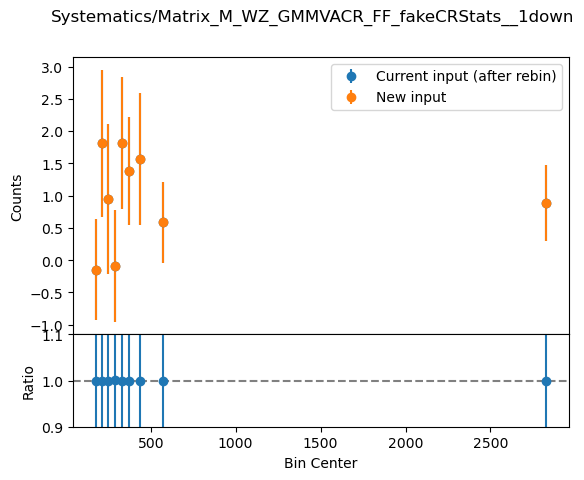

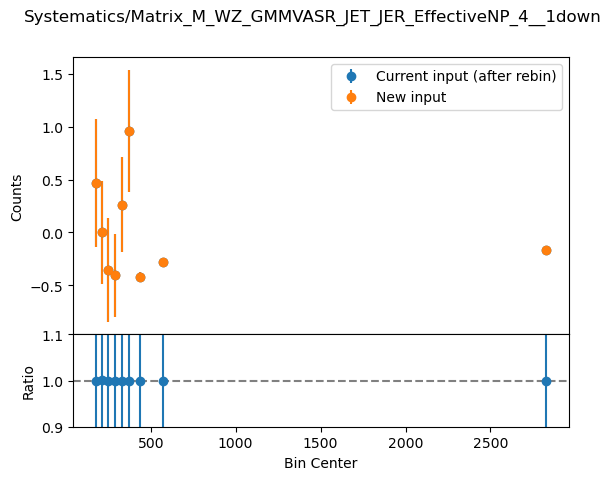

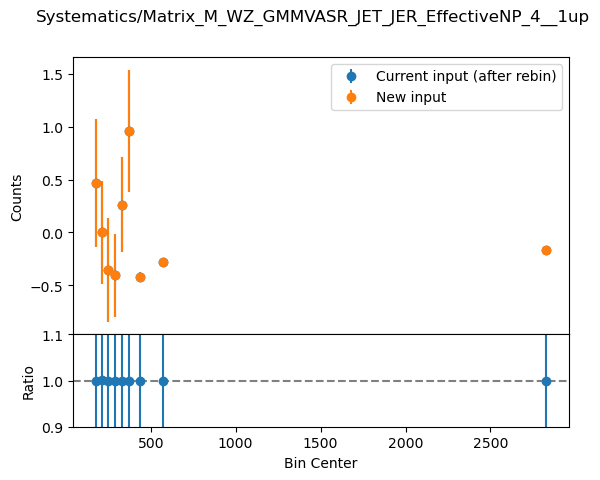

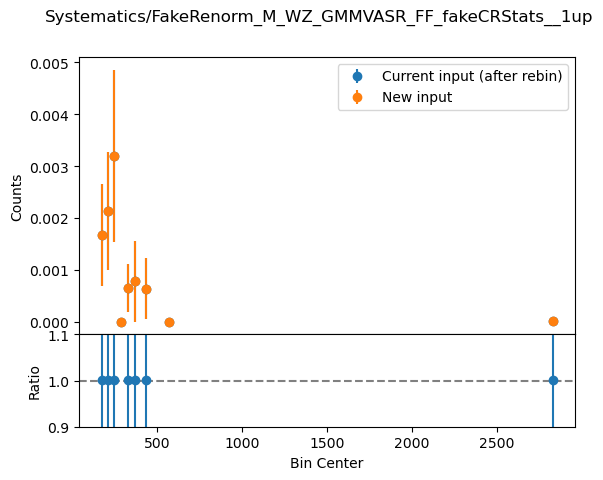

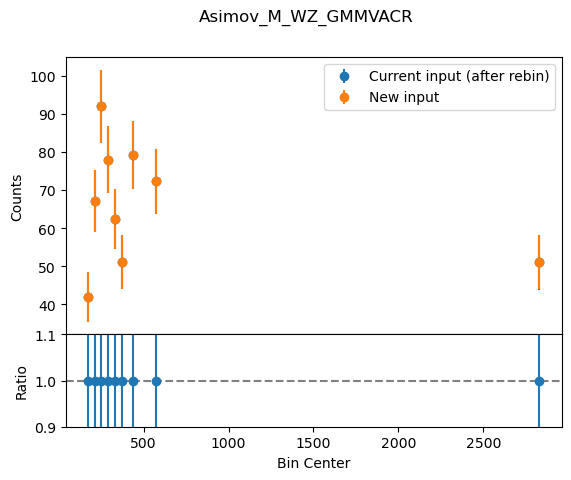

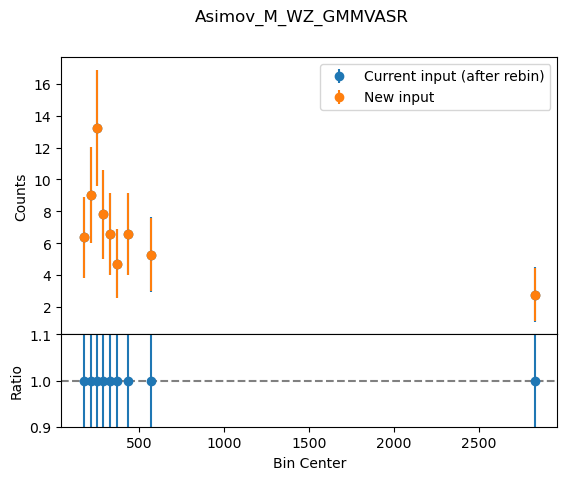

In [7]:
diff_hists = {}
for key in tqdm(test_histo_keys):
    if key.startswith('Systematics/HVTqq') or key.startswith('HVT'):
        continue
    # if key not in new_input:
    #     continue 
    two_hists = rebin_n_compare(current_input, new_input, key)
    if two_hists is not None:
        try:
            fig, ax1, ax2 = plot_ratio(two_hists)
        except Exception as e:
            print(f"Error plotting for key {key}: {e}")
            plt.close(fig)  # Close the figure if an error occurs to avoid memory issues
            continue
        
        fig.suptitle(key)
        diff_hists[key] = fig